In [1]:
#@title # **Projekt: EA vs. Hybrid-EA für TSP (kroA100)**
#@markdown Führen Sie diese Zelle aus, um das gesamte Experiment zu starten.
#@markdown Die Implementierung folgt dem detaillierten Projektplan, inklusive:
#@markdown 1.  Setup und Laden der TSP-Daten (`kroA100`).
#@markdown 2.  Implementierung des reinen Evolutionären Algorithmus (EA).
#@markdown 3.  Implementierung der 2-opt Tabu-Suche.
#@markdown 4.  Implementierung des hybriden (memetischen) Algorithmus.
#@markdown 5.  Durchführung der Experimente mit mehreren Läfen.
#@markdown 6.  Logging, statistische Auswertung und Visualisierung der Ergebnisse.

# ==============================================================================
# 1. SETUP UND ABHÄNGIGKEITEN
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu
from deap import base, creator, tools, algorithms
from deap.base import  Toolbox
from deap.tools import Statistics
from tabu_search import generate_neighbours, tabu_search
from time import perf_counter
import random
import time
import pandas as pd
from utils import kroA100_data_string
from numpy.typing import NDArray


print("Abschnitt 1: Lade Abhängigkeiten...")

# Globale Variable zur Zählung der Fitness-Evaluationen
FITNESS_COUNTER = 0

# ==============================================================================
# 2. TSP-DATEN LADEN UND HELFERFUNKTIONEN
# ==============================================================================
print("Abschnitt 2: Lade und verarbeite TSP-Daten (kroA100)...")


Abschnitt 1: Lade Abhängigkeiten...
Abschnitt 2: Lade und verarbeite TSP-Daten (kroA100)...


In [2]:
# --- Experiment-Parameter (angepasst für schnellere Laufzeit) ---
# Für finale Ergebnisse können diese Werte wieder erhöht werden (z.B. NUM_RUNS=30, NUM_GENERATIONS=200)
NUM_RUNS = 5              # Reduziert von 10 für schnellere Demonstration
NUM_GENERATIONS = 5    # Reduziert von 200
POP_SIZES = [10]
TRUNCATION_PERCENTAGE = 0.2
MUTATION_RATE = 0.2
# Tabu-Search-Parameter
TS_ITERATIONS = 10        # Reduziert von 15, um die teure lokale Suche zu beschleunigen
TS_TENURE = 20
# Hybrid-Parameter
HYBRID_TS_START_GENERATION = NUM_GENERATIONS // 2
HYBRID_TS_IMPROVE_PERCENTAGE = 0.2

CITY_INDICES  = set(range(100))

# class Point:
#     def __init__(self, index, x, y):
#         self.id = index
#         self.x = x
#         self.y = y



In [3]:
def parse_tsp_data(data:str)->NDArray:
    """Parst die Koordinaten aus den TSP-Daten."""
    "data is a huge string for now"
    coords = []
    in_coord_section = False
    for line in data.splitlines():
        if "NODE_COORD_SECTION" in line:
            in_coord_section = True
            continue
        if "EOF" in line:
            break
        if in_coord_section and line.strip():
            parts = line.strip().split()
            if len(parts) == 3:
                coords.append((float(parts[1]), float(parts[2])))
    return np.array(coords)

def get_distance_matrix(coords:NDArray)->NDArray:
    """Erstellt eine Distanzmatrix aus den Koordinaten."""
    num_cities = len(coords) # n_rows for 2D array
    dist_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(i, num_cities):
            dist = np.linalg.norm(coords[i] - coords[j])
            dist_matrix[i, j] = dist_matrix[j, i] = dist
    return dist_matrix


In [4]:
# Daten direkt aus dem String laden
coords = parse_tsp_data(kroA100_data_string)
if len(coords) > 0:
    dist_matrix = get_distance_matrix(coords)
    NUM_CITIES = len(coords)
    KROA100_OPTIMUM = 21282
    print(f"Daten für kroA100 ({NUM_CITIES} Städte) erfolgreich aus internem String geladen.")
else:
    print("Konnte TSP-Daten nicht parsen. Das Skript wird beendet.")
    exit()


Daten für kroA100 (100 Städte) erfolgreich aus internem String geladen.


In [5]:


#TODO: get rid of global variable, can be attribute of a config class or just pass it to func and receive it again
def calculate_tour_length(tour:list[int], dist_matrix:NDArray)->float:
    """Berechnet die Gesamtlänge einer Tour und zählt die Evaluation."""
    global FITNESS_COUNTER
    FITNESS_COUNTER += 1
    total_length = 0
    num_cities = len(tour)
    for i in range(num_cities):
        total_length += dist_matrix[tour[i], tour[(i + 1) % num_cities]]
    return total_length


# ==============================================================================
# 3. ALGORITHMUS-STEUERUNG UND EXPERIMENT-SETUP
# ==============================================================================
print("Abschnitt 3: Definiere Experiment-Steuerung...")


def evaluate(individual):
    return (calculate_tour_length(individual, dist_matrix),)  # DEAP erwartet Tupel

def record_log(gen, population,log_book:list)->list:
    logbook = log_book
    best = tools.selBest(population, 1)[0]
    logbook.append([
        gen,
        FITNESS_COUNTER,
        best.fitness.values[0],
        np.mean([ind.fitness.values[0] for ind in population])
    ])
    
    return logbook

def run_ea(pop_size, num_generations, dist_matrix):
    """EA-Implementierung mit DEAP (ersetzt eigene EA-Logik)."""
    global FITNESS_COUNTER
    FITNESS_COUNTER = 0
    start_time = perf_counter()

    # Definiere Fitness und Individuum-Typ
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)


    toolbox = Toolbox()
    toolbox.register("indices", random.sample, range(NUM_CITIES), NUM_CITIES)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxOrdered)  # entspricht Order Crossover
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # ähnliche Wirkung wie Inversion
    toolbox.register("select", tools.selBest)  # ähnlich Truncation (bessere kann man verwenden)

    # Initialisierung
    pop = toolbox.population(n=pop_size)
    for ind in pop:
        assert len(ind) == NUM_CITIES, f"Individuum hat ungültige Länge: {len(ind)} statt {NUM_CITIES}"
    hof = tools.HallOfFame(1)  # Speichert bestes Individuum

    stats = Statistics(lambda ind: ind.fitness.values[0])
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    
    # Evaluieren der Initialpopulation
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
   
    logbook = []
    logbook = record_log(0, pop,logbook)

    for gen in range(1, num_generations + 1):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        # 🛡️ Validierung der Nachkommen
        for i, ind in enumerate(offspring):
            if len(ind) != NUM_CITIES or set(ind) != set(range(NUM_CITIES)):
                print(f"[WARNUNG] Ungültiges Individuum in Generation {gen}, Index {i}: {ind}")
                # Ersetze durch korrektes neues Individuum
                offspring[i] = creator.Individual(random.sample(range(NUM_CITIES), NUM_CITIES))


        # Crossover und Mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.9:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Neue Fitness auswerten
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        logbook = record_log(gen, pop,logbook)

    print(f"\n    >> [EA] Laufzeit für diesen Run: {perf_counter() - start_time:.2f} Sekunden")
    best_ind = tools.selBest(pop, 1)[0]
    return best_ind.fitness.values[0], list(best_ind), pd.DataFrame(logbook, columns=[
        'Generation', 'Gesamte_Fitness_Evaluations', 'Beste_Fitness_Generation', 'Avg_Fitness_Generation'
    ])


def run_hybrid_ea(pop_size, num_generations, dist_matrix):
    """Hybrid-EA mit DEAP: EA + Tabu-Suche auf besten Individuen in späteren Generationen."""
    global FITNESS_COUNTER
    FITNESS_COUNTER = 0

    # Nur einmal definieren (falls mehrfach ausgeführt wird)
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = Toolbox()
    toolbox.register("indices", random.sample, range(NUM_CITIES), NUM_CITIES)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # def evaluate(individual):
    #     return (calculate_tour_length(individual, dist_matrix),)

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selBest)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    stats = Statistics(lambda ind: ind.fitness.values[0])
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    

    # Initiale Fitness-Berechnung
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    logbook = []
    logbook = record_log(0, pop,logbook)

    tabu_total_time = 0.0
    for gen in range(1, num_generations + 1):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Crossover & Mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.9:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        # Lokale Verbesserung via Tabu-Suche ab definierter Generation
        # Lokale Verbesserung via EXTERNER Tabu-Suche
        if gen >= HYBRID_TS_START_GENERATION:
            gen_tabu_start = perf_counter()
            'class Point only used here in the notebook'
            points = [(i, x, y) for i, (x, y) in enumerate(coords)]
            dict_of_neighbours = generate_neighbours(points)

            offspring.sort(key=lambda ind: ind.fitness.values[0] if ind.fitness.valid else float('inf'))
            num_to_improve = max(1, int(pop_size * HYBRID_TS_IMPROVE_PERCENTAGE))


            for i in range(num_to_improve):
                tour = offspring[i]
                tour_indices = list(tour)
                cost = calculate_tour_length(tour_indices, dist_matrix)

                # 🕒 Starte Zeitmessung für Tabu-Suche
                start_tabu = perf_counter()

                improved_tour, improved_cost = tabu_search(
                    tour_indices, cost, dict_of_neighbours,
                    iters=TS_ITERATIONS, size=TS_TENURE, n_opt=1
                )

                # 🕒 Beende Zeitmessung
                tabu_total_time += perf_counter() - start_tabu

                offspring[i][:] = improved_tour
                # Schutz gegen fehlerhafte Längen oder Duplikate
                
                if len(set(improved_tour)) != NUM_CITIES:
                    
                    print(f"[FEHLER] Tabu-Suche lieferte ungültige Tour (Länge: {len(improved_tour)}):")
                    print(f"length improved tour {len(improved_tour) = }")
                    print(f"start {improved_tour[0]}")
                    print(f"end {improved_tour[-1]}")
                    left_out_cities = CITY_INDICES - set(improved_tour) 

                    # print(len(set(improved_tour)))
                    # print(NUM_CITIES)
                    print(left_out_cities)
                    print("/"*99)
                    improved_tour = random.sample(range(NUM_CITIES), NUM_CITIES)
                    offspring[i][:] = improved_tour
                offspring[i].fitness.values = (improved_cost,)

            gen_tabu_end = perf_counter()
            gen_tabu_time = gen_tabu_end - gen_tabu_start
            print(f"    [GEN {gen}] Tabu-Suche-Zeit: {gen_tabu_time:.2f} Sek.")
            tabu_total_time += gen_tabu_time

        # Ungültige Individuen evaluieren
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        logbook = record_log(gen, pop,logbook)

    print(f"  >> [Hybrid-EA] Gesamte Tabu-Suche-Zeit in diesem Run: {tabu_total_time:.2f} Sekunden")

    best_ind = tools.selBest(pop, 1)[0]
    return best_ind.fitness.values[0], list(best_ind), pd.DataFrame(logbook, columns=[
        'Generation', 'Gesamte_Fitness_Evaluations', 'Beste_Fitness_Generation', 'Avg_Fitness_Generation'
    ])


Abschnitt 3: Definiere Experiment-Steuerung...


In [6]:

# ==============================================================================
# 4. EXPERIMENTE DURCHFÜHREN UND DATEN SAMMELN
# ==============================================================================
print("Abschnitt 4: Führe Experimente durch (dies kann einige Minuten dauern)...")

all_results = {}
all_logs = {}
best_tours = {}

configs = {
    'EA': run_ea,
    'Hybrid': run_hybrid_ea
}
"all action happens below"
start_time = time.time()
for pop_size in POP_SIZES:
    for name, func in configs.items():
        key = f'{name}_{pop_size}'
        print(f"  -> Starte Läufe für: {key}")

        final_fitnesses_run = []
        run_logs = []
        best_tour_run = None
        best_fitness_run = float('inf')

        for i in range(NUM_RUNS):
            print(f"    -> Run {i+1}/{NUM_RUNS}...", end="")
            final_fitness, final_tour, log_data = func(pop_size, NUM_GENERATIONS, dist_matrix)
            final_fitnesses_run.append(final_fitness)
            run_logs.append(pd.DataFrame(log_data, columns=['Generation', 'Gesamte_Fitness_Evaluations', 'Beste_Fitness_Generation', 'Avg_Fitness_Generation']))

            if final_fitness < best_fitness_run:
                best_fitness_run = final_fitness
                best_tour_run = final_tour
            print(f"    -> Run {i+1}/{NUM_RUNS} fertig \n", end="" )

        all_results[key] = final_fitnesses_run
        all_logs[key] = run_logs
        best_tours[key] = best_tour_run

end_time = time.time()
print(f"\nExperimente abgeschlossen in {end_time - start_time:.2f} Sekunden.")

Abschnitt 4: Führe Experimente durch (dies kann einige Minuten dauern)...
  -> Starte Läufe für: EA_10
    -> Run 1/5...
    >> [EA] Laufzeit für diesen Run: 0.01 Sekunden
    -> Run 1/5 fertig 
    -> Run 2/5...
    >> [EA] Laufzeit für diesen Run: 0.01 Sekunden
    -> Run 2/5 fertig 
    -> Run 3/5...
    >> [EA] Laufzeit für diesen Run: 0.00 Sekunden
    -> Run 3/5 fertig 
    -> Run 4/5...
    >> [EA] Laufzeit für diesen Run: 0.00 Sekunden
    -> Run 4/5 fertig 
    -> Run 5/5...
    >> [EA] Laufzeit für diesen Run: 0.00 Sekunden
    -> Run 5/5 fertig 
  -> Starte Läufe für: Hybrid_10
    -> Run 1/5...    [GEN 2] Tabu-Suche-Zeit: 39.96 Sek.
    [GEN 3] Tabu-Suche-Zeit: 36.78 Sek.
    [GEN 4] Tabu-Suche-Zeit: 39.09 Sek.
    [GEN 5] Tabu-Suche-Zeit: 35.75 Sek.
  >> [Hybrid-EA] Gesamte Tabu-Suche-Zeit in diesem Run: 303.16 Sekunden
    -> Run 1/5 fertig 
    -> Run 2/5...    [GEN 2] Tabu-Suche-Zeit: 37.10 Sek.
    [GEN 3] Tabu-Suche-Zeit: 38.00 Sek.
    [GEN 4] Tabu-Suche-Zeit: 37.34 


Abschnitt 5: Erstelle Auswertungen und Visualisierungen...


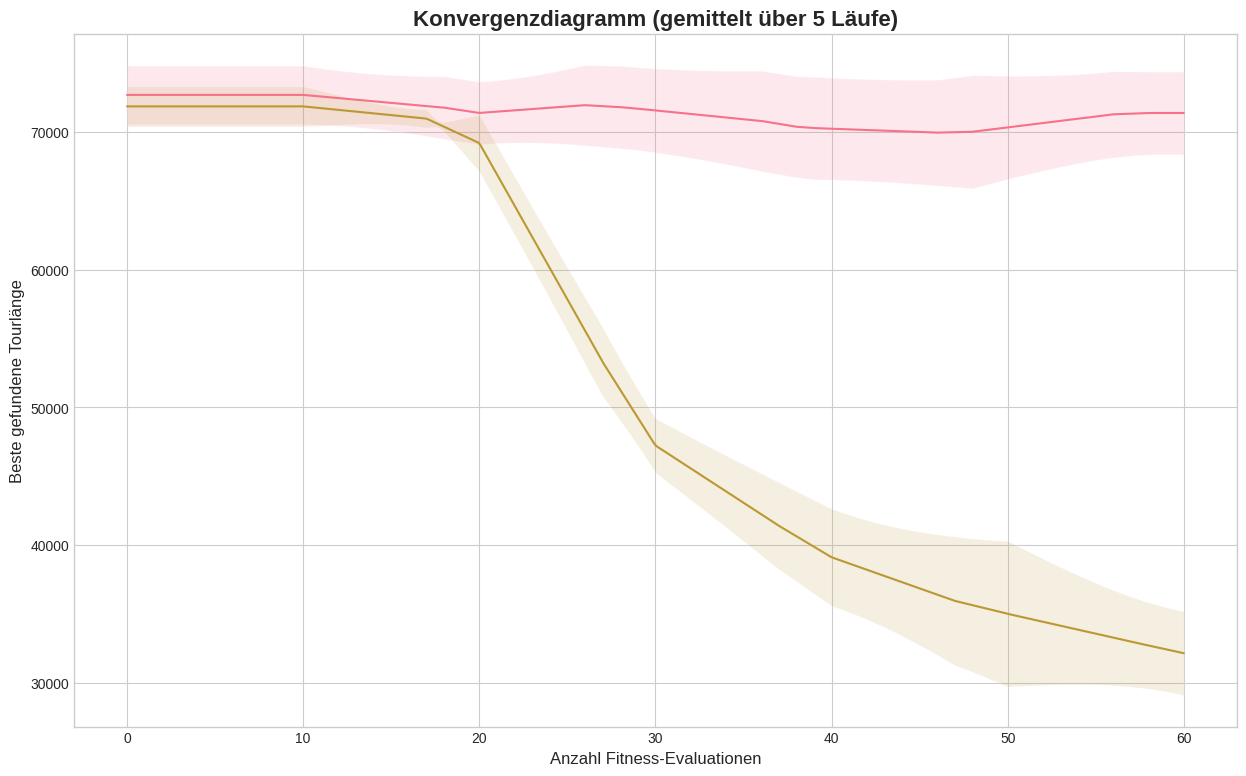

In [7]:

# ==============================================================================
# 5. AUSWERTUNG, VISUALISIERUNG UND STATISTISCHE TESTS
# ==============================================================================
print("\nAbschnitt 5: Erstelle Auswertungen und Visualisierungen...")
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# --- 7.1 KONVERGENZDIAGRAMME ---
plt.figure(figsize=(15, 9))
plt.title(f'Konvergenzdiagramm (gemittelt über {NUM_RUNS} Läufe)', fontsize=16, weight='bold')
plt.xlabel('Anzahl Fitness-Evaluationen', fontsize=12)
plt.ylabel('Beste gefundene Tourlänge', fontsize=12)

max_evals = 0
for key in all_logs:
    for log in all_logs[key]:
        if not log.empty:
            max_evals = max(max_evals, log['Gesamte_Fitness_Evaluations'].max())

if max_evals > 0:
    eval_points = np.linspace(0, max_evals, 500)

    for key, logs in all_logs.items():
        interpolated_fitnesses = []
        for log in logs:
            if log.empty: continue
            # np.interp erfordert, dass die x-Punkte (Evaluations) ansteigen
            log = log.drop_duplicates(subset='Gesamte_Fitness_Evaluations', keep='first')
            interpolated = np.interp(eval_points, log['Gesamte_Fitness_Evaluations'], log['Beste_Fitness_Generation'])
            interpolated_fitnesses.append(interpolated)

        if not interpolated_fitnesses: continue

        mean_fitness = np.mean(interpolated_fitnesses, axis=0)
        std_fitness = np.std(interpolated_fitnesses, axis=0)

        plt.plot(eval_points, mean_fitness, label=key)
        plt.fill_between(eval_points, mean_fitness - std_fitness, mean_fitness + std_fitness, alpha=0.15)

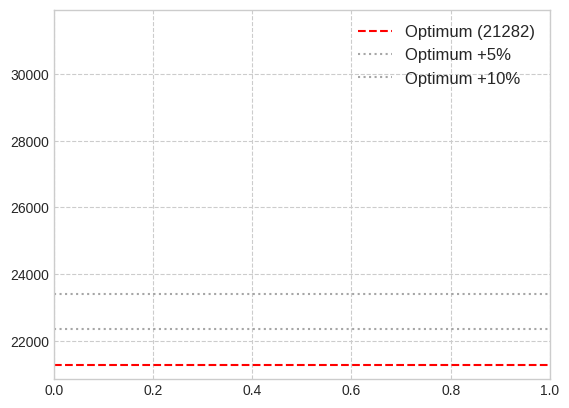

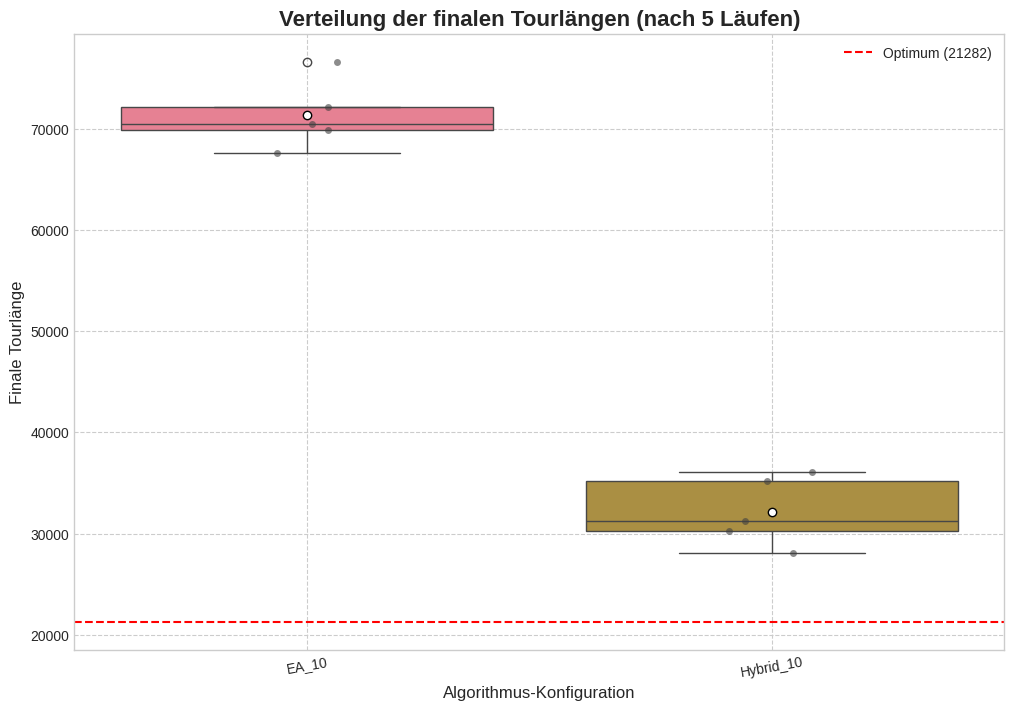

In [8]:

# Optimum und Prozentlinien
plt.axhline(KROA100_OPTIMUM, color='red', linestyle='--', label=f'Optimum ({KROA100_OPTIMUM})')
plt.axhline(KROA100_OPTIMUM * 1.05, color='gray', linestyle=':', alpha=0.7, label='Optimum +5%')
plt.axhline(KROA100_OPTIMUM * 1.10, color='gray', linestyle=':', alpha=0.7, label='Optimum +10%')

plt.legend(fontsize=12)
plt.ylim(bottom=KROA100_OPTIMUM * 0.98, top=KROA100_OPTIMUM*1.5)
plt.grid(True, which='both', linestyle='--')
plt.show()

# --- 7.2 BOX-PLOTS DER FINALEN ERGEBNISSE ---
plt.figure(figsize=(12, 8))
plt.title(f'Verteilung der finalen Tourlängen (nach {NUM_RUNS} Läufen)', fontsize=16, weight='bold')
df_results = pd.DataFrame(all_results)
sns.boxplot(data=df_results, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
sns.stripplot(data=df_results, color=".25", size=5, alpha=0.6)
plt.ylabel('Finale Tourlänge', fontsize=12)
plt.xlabel('Algorithmus-Konfiguration', fontsize=12)
plt.axhline(KROA100_OPTIMUM, color='red', linestyle='--', label=f'Optimum ({KROA100_OPTIMUM})')
plt.legend()
plt.xticks(rotation=10)
plt.grid(True, which='both', linestyle='--')
plt.show()

In [9]:

# --- 7.3 STATISTISCHE TESTS ---
print("\n--- Statistische Auswertung ---")

def compare_algorithms(name1:str, name2:str):
    results1 = all_results.get(name1)
    results2 = all_results.get(name2)

    if not results1 or not results2:
        print(f"Konnte Ergebnisse für '{name1}' oder '{name2}' nicht finden.")
        return

    print(f"\nVergleich: {name1} vs. {name2}")

    # Shapiro-Wilk-Test für Normalität
    p_shapiro1 = shapiro(results1).pvalue
    p_shapiro2 = shapiro(results2).pvalue
    print(f"Shapiro-Wilk p-Wert für {name1}: {p_shapiro1:.4f}")
    print(f"Shapiro-Wilk p-Wert für {name2}: {p_shapiro2:.4f}")

    if p_shapiro1 <= 0.05 or p_shapiro2 <= 0.05:
        print("Mindestens eine Verteilung ist nicht normalverteilt. Wir verwenden den Mann-Whitney-U-Test.")
        # Mann-Whitney-U-Test
        u_stat, p_value = mannwhitneyu(results1, results2, alternative='two-sided')
        print(f"Mann-Whitney-U-Test p-Wert: {p_value:.4f}")
        if p_value < 0.05:
            winner = name1 if np.mean(results1) < np.mean(results2) else name2
            print(f"-> Der Unterschied ist statistisch signifikant. {winner} ist besser.")
        else:
            print("-> Der Unterschied ist nicht statistisch signifikant.")
    else:
        print("Daten scheinen normalverteilt zu sein. (t-Test wäre anwendbar, wir bleiben aber konsistent beim U-Test)")

# keys of all_result dictionary are like follows and are pairwise compared like below
# key = f'{name}_{pop_size}'

# compare_algorithms('EA_100', 'Hybrid_100')
# compare_algorithms('EA_50', 'Hybrid_50')
# compare_algorithms('Hybrid_50', 'Hybrid_100')

for pop_size in POP_SIZES:
    compare_algorithms(f'EA_{pop_size}', f'Hybrid_{pop_size}')



--- Statistische Auswertung ---

Vergleich: EA_10 vs. Hybrid_10
Shapiro-Wilk p-Wert für EA_10: 0.6922
Shapiro-Wilk p-Wert für Hybrid_10: 0.5993
Daten scheinen normalverteilt zu sein. (t-Test wäre anwendbar, wir bleiben aber konsistent beim U-Test)



Beste gefundene Tour stammt von 'Hybrid_10' mit einer Länge von 28054.26


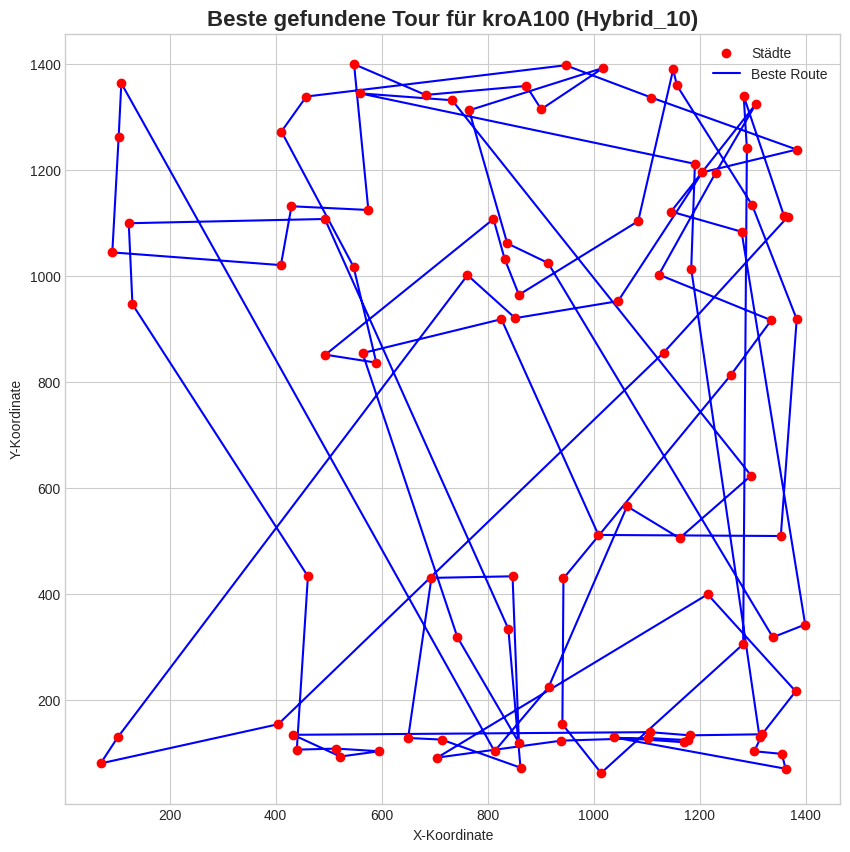

In [10]:


# --- 7.4 VISUALISIERUNG DER BESTEN TOUR ---
# Finde die absolut beste Tour über alle Konfigurationen und Läufe
best_overall_fitness = float('inf')
best_overall_tour = None
best_overall_key = ""

for key, fitness_list in all_results.items():
    if not fitness_list: continue
    min_fitness_in_key = min(fitness_list)
    if min_fitness_in_key < best_overall_fitness:
        best_overall_fitness = min_fitness_in_key
        best_overall_tour = best_tours[key]
        best_overall_key = key

print(f"\nBeste gefundene Tour stammt von '{best_overall_key}' mit einer Länge von {best_overall_fitness:.2f}")

plt.figure(figsize=(10, 10))
plt.title(f'Beste gefundene Tour für kroA100 ({best_overall_key})', fontsize=16, weight='bold')
# Städte plotten
plt.scatter(coords[:, 0], coords[:, 1], c='red', zorder=2, label='Städte')

# Tour plotten
if best_overall_tour:
    # Schließe die Tour für die Visualisierung
    plot_tour = best_overall_tour + [best_overall_tour[0]]
    tour_coords = coords[plot_tour]
    plt.plot(tour_coords[:, 0], tour_coords[:, 1], 'b-', zorder=1, label='Beste Route')
else:
    print("Keine gültige Tour zur Visualisierung gefunden.")

plt.xlabel('X-Koordinate')
plt.ylabel('Y-Koordinate')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()
